# Exploring LiDAR point cloud data

## 0. Setup

### 0.1 Jupyter setup

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

### 0.2 Imports

In [2]:
import laspy
import numpy as np
import scipy.stats
import folium
import folium.plugins

from src.constants import USER_PATH
from src.utils.os import list_content

For an example on LiDAR processing in Python, see here: https://laspy.readthedocs.io/en/latest/complete_tutorial.html

## 1. Load data

Note: The data we have here seems to be from the ["Feliz Natal" region](https://www.paisagenslidar.cnptia.embrapa.br/search/?title__icontains=fnd&limit=20&offset=0) which is in the UTM21S coordinate zone.

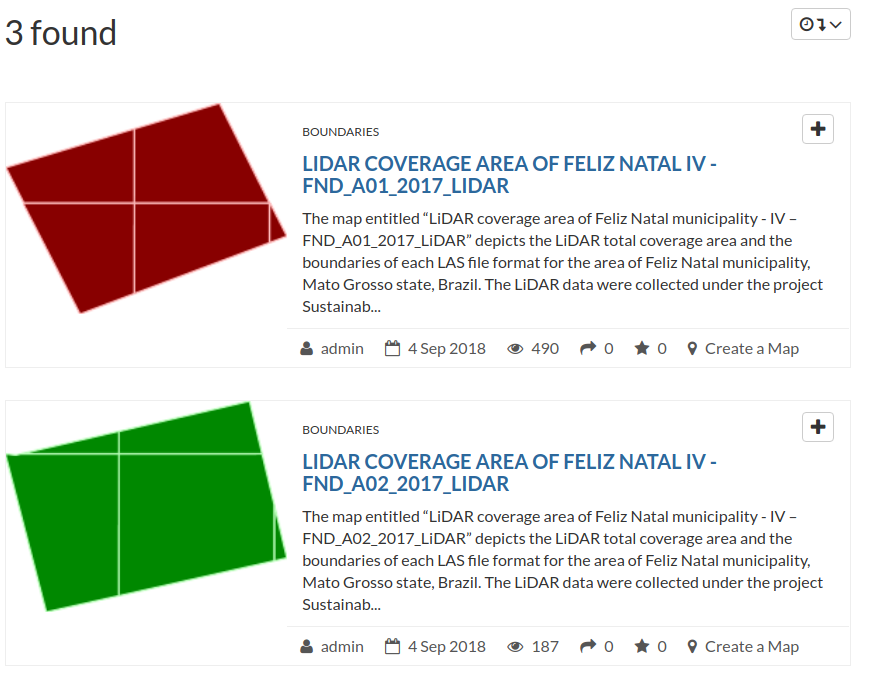

### 1.1 Loading the data in Python


In [8]:
sample_las_file = USER_PATH / "from_Edgar/lidar/FND_A03_2017_LiDAR/FND_A03_2017_laz/FNDL004C007.las"

In [4]:
las = laspy.read(sample_las_file)

In [5]:
print(las)

<LasData(1.2, point fmt: <PointFormat(1, 0 bytes of extra dims)>, 14190069 points, 0 vlrs)>


### 1.2 Loading and checking the data in R
Next, let us quickly check the integrity of the point cloud in R

In [6]:
las_file_path_r = str(sample_las_file)

In [7]:
%%R -i las_file_path_r  # pass python variable to R for using lidR package in R

# Load lidR package
library(lidR)

# Read in LAS file
las <- readLAS(las_file_path_r)
# Print summary of file
print(las)
# Check data integrity
las_check(las)

R[write to console]: Loading required package: raster

R[write to console]: Loading required package: sp

R[write to console]: lidR 3.0.4 using 24 threads. Help on <gis.stackexchange.com>. Bug report on <github.com/Jean-Romain/lidR>.



class        : LAS (v1.2 format 1)
memory       : 1.1 Gb 
extent       : 712000, 713000, 8642000, 8643000 (xmin, xmax, ymin, ymax)
coord. ref.  : NA 
area         : 1 kunits²
points       : 14.19 million points
density      : 14.19 points/units²

 Checking the data
  - Checking coordinates... ✓
  - Checking coordinates type... ✓
  - Checking coordinates quantization... ✓
  - Checking attributes type... ✓
  - Checking ReturnNumber validity... ✓
  - Checking NumberOfReturns validity... ✓
  - Checking ReturnNumber vs. NumberOfReturns... ✓
  - Checking RGB validity... ✓
  - Checking absence of NAs... ✓
  - Checking duplicated points...
   ⚠ 874 points are duplicated and share XYZ coordinates with other points
  - Checking degenerated ground points... ✓
  - Checking attribute population... ✓
  - Checking gpstime incoherances ✓
  - Checking flag attributes... ✓
  - Checking user data attribute... ✓
 Checking the header
  - Checking header completeness... ✓
  - Checking scale factor validity.

We see that the data is mostly ok (apart from 874 duplicates), but the height is not yet normalized. 
We'll still need to do that later, especially for the biomass estimate.

### 1.3 Inspecting the data in Python

In [9]:
# Inspect xyz offsets
las.header.offsets

array([-0., -0., -0.])

In [10]:
# Inspect xyz scales
las.header.scales

array([0.01, 0.01, 0.01])

In [11]:
# Find out what the point format looks like.
for dimension in las.point_format.dimensions:
    print(dimension.name)

X
Y
Z
intensity
return_number
number_of_returns
scan_direction_flag
edge_of_flight_line
classification
synthetic
key_point
withheld
scan_angle_rank
user_data
point_source_id
gps_time


In [12]:
# Get z coordinates 
las.z

<ScaledArrayView([372.73 374.17 374.04 ... 360.67 360.26 360.32])>

In [13]:
# Check point record
las.points

<PackedPointRecord(fmt: <PointFormat(1, 0 bytes of extra dims)>, len: 14190069, point size: 28)>

In [14]:
# Indicate valid values
las.header.mins

array([7.1200e+05, 8.6420e+06, 3.5293e+02])

In [15]:
las.header.maxs

array([7.12999990e+05, 8.64299999e+06, 4.03420000e+02])

## 2 Geolocating the ALS Survey site

In [17]:
import shapely.geometry
import geopandas as gpd
from src.constants import WGS84

xmin, xmax = las.header.x_min, las.header.x_max
ymin, ymax = las.header.y_min, las.header.y_max
las_bbox = shapely.geometry.box(xmin, ymin, xmax, ymax)

UTM21S = "EPSG:32721"

In [18]:
# Create geospatial dataframe for region of interest
roi =  gpd.GeoDataFrame(geometry=[las_bbox], crs=UTM21S).to_crs(WGS84)

### 2.1 Determine the spatial characteristics

In [23]:
print(f"Region of interest area in ha: {roi.to_crs(UTM21S).area.values / 1e4}")
print(f"Point density is: {len(las.points) / roi.to_crs(UTM21S).area.values[0]:.2f} returns/m2")

Region of interest area in ha: [99.99800001]
Point density is: 14.19 returns/m2


This is great, the point density and size as determined in python agrees with what the lidR package extracted.

### 2.2 Plot the location

In [19]:
import folium
import folium.plugins 

# Create map and add layers
world_map = folium.Map(
    location=roi.geometry.values[0].centroid.coords[0][::-1],
    control_scale=True,
    zoom_start=10,
    tiles="OpenStreetMap",
)
# Add ROI
roi_style = {"fillColor": "#2a74ac", "color": "#2a74ac"}
folium.GeoJson(
    data=roi.__geo_interface__,
    name="Lidar BBox",
    style_function=lambda x: roi_style,
).add_to(world_map)
# Add satellite image overlay
folium.TileLayer(
    tiles=(
        "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/"
        "MapServer/tile/{z}/{y}/{x}"
    ),
    attr="Esri",
    name="Esri Satellite",
    overlay=False,
    control=True,
).add_to(world_map)
# Add minimap
folium.plugins.MiniMap(zoom_level_fixed=2).add_to(world_map)
# Add map controls
folium.LayerControl().add_to(world_map)

world_map

### 2.3 Plot the height histogram

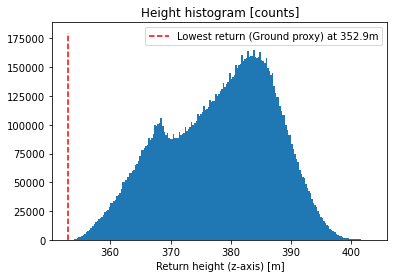

In [24]:
import matplotlib.pyplot as plt
plt.hist(las.z.scaled_array(), bins=200);
plt.vlines(las.header.z_min, 0, 1.8e5, color="red", linestyle="dashed", label=f"Lowest return (Ground proxy) at {las.header.z_min:.1f}m")
plt.title("Height histogram [counts]")
plt.xlabel("Return height (z-axis) [m]")
plt.legend();

## 3. Testing out the Longo 2016 formula

To test the Longo formula, we'll simply use the lowest return as a proxy for the ground for now, 
just to check that the ACD value is in the right order of magnitude. For the full analysis we will fit the
ground to the LiDAR point cloud and then get the more accurate height distribution for ACD calculations. More on that
later. 

First, here's the Longo formula

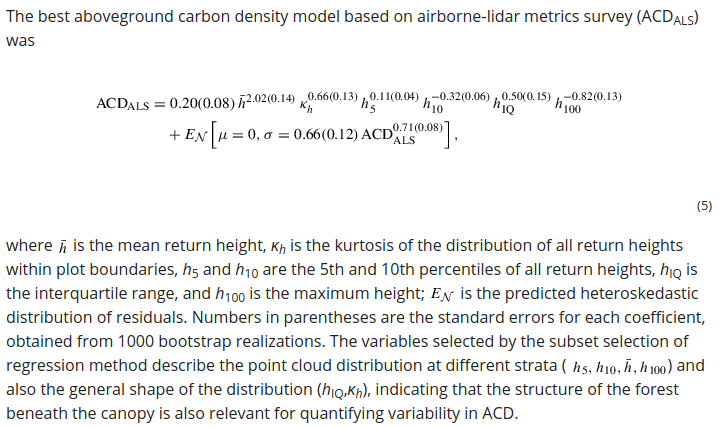

Let's type that in code

In [25]:
def longo_formula(height_mean, 
                  height_kurtosis, 
                  height_5, 
                  height_10, 
                  height_iq, 
                  height_100):
    
    return (0.20 
            * (height_mean ** 2.02) 
            * (height_kurtosis ** 0.66) 
            * (height_5 ** 0.11)
            * (height_10 ** -0.32)
            * (height_iq ** 0.50)
            * (height_100 ** -0.82)
           )

Next, let us get the relevant statistics from our lidar point cloud data to estimate the biomass

In [26]:
import scipy.stats
# estimated ground height:
ground = las.header.z_min # very crude ground estimate (352m)
heights = las.z.scaled_array() - ground

# Calculate return height characteristics
height_mean = np.mean(heights)
height_5, height_10, height_25, height_75, height_98 = np.percentile(heights, [5, 10, 25, 75, 98])
height_100 = max(heights)
height_iq = height_75 - height_25
height_kurtosis = scipy.stats.kurtosis(heights, fisher=False, bias=False) # bias seems to make no difference

In [27]:
longo_formula(height_mean,
              height_kurtosis, 
              height_5, 
              height_10, 
              height_iq, 
              height_100) # in kgC / m2

20.035477165395612

Wonderful, this gives an ACD estimate of 20 kgC/m2 (equiv. 200 MgC/ha), which is in line with the order of magnitude of 
Longo values for intact Amazon forest sites.

## 4. Performing a ground classification and normalising the height

In [30]:
%%time  
%%R
# Use cloth smoothing function for ground classification
mycsf <- csf(sloop_smooth = TRUE, class_threshold = 1, cloth_resolution = 1, time_step = 1)

# Classify ground
las <- classify_ground(las, mycsf)

# Normalise las data
nlas <- normalize_height(las, knnidw())

R[write to console]: Original dataset already contains 179000 ground points. These points were reclassified as 'unclassified' before performing a new ground classification.



CPU times: user 42min 22s, sys: 9min 50s, total: 52min 13s---------------------] 1% (24 threads)[=-------------------------------------------------] 2% (24 threads)[=-------------------------------------------------] 3% (24 threads)[==------------------------------------------------] 4% (24 threads)[==------------------------------------------------] 5% (24 threads)[===-----------------------------------------------] 6% (24 threads)[===-----------------------------------------------] 7% (24 threads)[====----------------------------------------------] 8% (24 threads)[====----------------------------------------------] 9% (24 threads)[=====---------------------------------------------] 10% (24 threads)[=====---------------------------------------------] 11% (24 threads)[======--------------------------------------------] 12% (24 threads)[======--------------------------------------------] 13% (24 threads)[=======-------------------------------------------] 14% (24 threads)[=======-------

In [56]:
%%time
%%R -o normalized_heights
normalized_heights <- nlas@data[[3]]

CPU times: user 14.7 ms, sys: 34.1 ms, total: 48.8 ms
Wall time: 57.1 ms


In [57]:
%%time
# Calculate return height characteristics
nheight_mean = np.mean(normalized_heights)
nheight_5, nheight_10, nheight_25, nheight_75, nheight_98 = np.percentile(normalized_heights, [5, 10, 25, 75, 98])
nheight_100 = max(normalized_heights)
nheight_iq = nheight_75 - nheight_25
nheight_kurtosis = scipy.stats.kurtosis(normalized_heights, fisher=False, bias=False) # bias seems to make no difference

CPU times: user 2 s, sys: 311 ms, total: 2.31 s
Wall time: 2.31 s


In [58]:
longo_formula(nheight_mean,
              nheight_kurtosis, 
              nheight_5, 
              nheight_10, 
              nheight_iq, 
              nheight_100) # in kgC / m2

11.576107838173325

Wow! This is quite a significant difference (almost 50% or 8.5 kgC/m2) with this ground model
to the 20 kgC/m2 that we found before. 

This tells us that height normalisation is crucial, and that our simple proxy above likely severely overestimated the ground biomass.

Let's do the same caluclation again, but this time with the ground classification that is 
already given in the dataset to see how much that differs from our cloth ground finding approach:

In [62]:
%%time  
%%R -o normalized_heights

# Read in las again
las <- readLAS(las_file_path_r)

# Normalise las data (this time using already classified ground points)
nlas <- normalize_height(las, knnidw())

CPU times: user 31min 10s, sys: 5min 23s, total: 36min 33s---------------------] 1% (24 threads)[=-------------------------------------------------] 2% (24 threads)[=-------------------------------------------------] 3% (24 threads)[==------------------------------------------------] 4% (24 threads)[==------------------------------------------------] 5% (24 threads)[===-----------------------------------------------] 6% (24 threads)[===-----------------------------------------------] 7% (24 threads)[====----------------------------------------------] 8% (24 threads)[====----------------------------------------------] 9% (24 threads)[=====---------------------------------------------] 10% (24 threads)[=====---------------------------------------------] 11% (24 threads)[======--------------------------------------------] 12% (24 threads)[======--------------------------------------------] 13% (24 threads)[=======-------------------------------------------] 14% (24 threads)[=======-------

In [64]:
%%time
%%R -o normalized_heights
normalized_heights <- nlas@data[[3]]

CPU times: user 15.4 ms, sys: 58 µs, total: 15.4 ms
Wall time: 14.9 ms


In [65]:
%%time
# Calculate return height characteristics
nheight_mean = np.mean(normalized_heights)
nheight_5, nheight_10, nheight_25, nheight_75, nheight_98 = np.percentile(normalized_heights, [5, 10, 25, 75, 98])
nheight_100 = max(normalized_heights)
nheight_iq = nheight_75 - nheight_25
nheight_kurtosis = scipy.stats.kurtosis(normalized_heights, fisher=False, bias=False) # bias seems to make no difference

longo_formula(nheight_mean,
              nheight_kurtosis, 
              nheight_5, 
              nheight_10, 
              nheight_iq, 
              nheight_100) # in kgC / m2

CPU times: user 1.88 s, sys: 104 ms, total: 1.98 s
Wall time: 1.98 s


11.575890383083664

Ok this is encouraging. At least the two different grounds as obtained from the original 
classification in the dataset and our cloth fitting approach gives the same value (up to 0.01 kgC/m2, which is negligible given the other errors.)

## Appendix: Investigating Longo 2016 Formula

Let's briefly sanity check the Longo formula, by using their data to see whether we end up with the same results

Link: https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2016GB005465&file=gbc20478-sup-0002-supplementary.txt

In [32]:
import pandas as pd

In [34]:
# Load longo data
longo_2016 = pd.read_csv("Longo_2016_data.csv").convert_dtypes()
print(f"There are {longo_2016.shape[0]} plots with {longo_2016.shape[1]} variables.")
longo_2016.head()

There are 407 plots with 98 variables.


,PLOT_ID,PLOT_AREA,LON_GNSS,LAT_GNSS,DIST_HIST,DATE_FI,ACD_FI,SIGMA_M_ACD_FI,SIGMA_A_ACD_FI,SIGMA_SZ_ACD_FI,...,ACD_GBM,SIGMA_C_ACD_GBM,SIGMA_R_ACD_GBM,SIGMA_P_ACD_GBM,SIGMA_ACD_GBM,ABCD_GBM,SIGMA_C_ABCD_GBM,SIGMA_R_ABCD_GBM,SIGMA_P_ABCD_GBM,SIGMA_ABCD_GBM
0,AND_P01_B01,2636.919,-46.8306,-2.5482,CVL1999+BRN2009,2013-08-22,7.2931,0.1201,0.9764,1.9637,...,7.8636,0.3569,0.4636,3.7619,3.8071,7.2050,0.3366,0.4718,3.6944,3.7396
1,AND_P02_B01,2525.592,-46.83,-2.5494,CVL1999+BRN2009,2013-08-22,10.4756,0.1519,1.013,2.8206,...,8.3667,0.3503,0.4202,3.7619,3.8014,7.6981,0.3371,0.4142,3.6944,3.7328
2,AND_P03_B01,2276.702,-46.8295,-2.5507,CVL1999+BRN2009,2013-08-22,8.9408,0.1555,0.9533,2.4074,...,7.1707,0.3757,0.5242,3.7619,3.8167,6.5113,0.3294,0.5486,3.6944,3.7494
3,AND_P04_B01,2294.573,-46.829,-2.5519,CVL1999+BRN2009,2013-08-22,10.4767,0.1178,1.1285,2.8209,...,9.2070,0.4053,0.3960,3.7619,3.8043,8.5681,0.3821,0.3429,3.6944,3.7299
4,AND_P05_B01,2329.407,-46.8322,-2.5489,CVL1999+BRN2009,2013-08-24,5.0432,0.0923,0.5308,1.3579,...,7.1098,0.2948,0.4056,3.7619,3.7951,6.3864,0.2692,0.4677,3.6944,3.7336


In [35]:
longo_AND = longo_2016[longo_2016["PLOT_ID"].str.contains("AND")]

In [37]:
longo_AND["DIST_HIST"] == "INT"  # Weird? Why is there no "INT" forest for AND, but Table 2 in the paper shows INT forest for AND?

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: DIST_HIST, dtype: boolean

In [39]:
longo_2016[["PLOT_ID"] + longo_2016.columns[longo_2016.columns.str.contains("ACD")].to_list()]

,PLOT_ID,ACD_FI,SIGMA_M_ACD_FI,SIGMA_A_ACD_FI,SIGMA_SZ_ACD_FI,SIGMA_ACD_FI,ACD_ALS,SIGMA_C_ACD_ALS,SIGMA_R_ACD_ALS,SIGMA_P_ACD_ALS,...,ACD_RFR,SIGMA_C_ACD_RFR,SIGMA_R_ACD_RFR,SIGMA_P_ACD_RFR,SIGMA_ACD_RFR,ACD_GBM,SIGMA_C_ACD_GBM,SIGMA_R_ACD_GBM,SIGMA_P_ACD_GBM,SIGMA_ACD_GBM
0,AND_P01_B01,7.2931,0.1201,0.9764,1.9637,2.1963,7.3771,2.2051,0.5078,2.7499,...,7.4482,1.3347,0.4993,4.3743,4.6005,7.8636,0.3569,0.4636,3.7619,3.8071
1,AND_P02_B01,10.4756,0.1519,1.013,2.8206,3.0009,7.6342,2.9790,0.2936,2.8181,...,7.8125,1.7839,0.4314,4.3743,4.7437,8.3667,0.3503,0.4202,3.7619,3.8014
2,AND_P03_B01,8.9408,0.1555,0.9533,2.4074,2.5939,5.5773,2.5884,0.2512,2.2516,...,6.8097,1.5581,0.6744,4.3743,4.6922,7.1707,0.3757,0.5242,3.7619,3.8167
3,AND_P04_B01,10.4767,0.1178,1.1285,2.8209,3.0406,9.5799,3.0314,0.2813,3.3146,...,9.4989,1.8305,0.5892,4.3743,4.7783,9.2070,0.4053,0.3960,3.7619,3.8043
4,AND_P05_B01,5.0432,0.0923,0.5308,1.3579,1.4609,6.1280,1.4600,0.2663,2.4084,...,6.1952,0.8958,0.5242,4.3743,4.4957,7.1098,0.2948,0.4056,3.7619,3.7951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,TSJ_P34_B01,2.3373,0.0205,0.1691,0.2337,0.2892,3.1108,0.2898,0.2509,1.4834,...,4.2967,0.2895,1.1134,4.3743,4.5230,4.9331,0.2507,0.5815,3.7619,3.8148
403,TSJ_P35_B01,3.0657,0.0327,0.1697,0.3066,0.3519,6.0157,0.3506,0.3276,2.3768,...,6.6913,0.3664,0.7544,4.3743,4.4539,6.4719,0.3053,0.5125,3.7619,3.8089
404,TSJ_P36_B01,2.2001,0.0221,0.0777,0.22,0.2344,4.4324,0.2323,0.3555,1.9106,...,4.3166,0.3040,0.8864,4.3743,4.4735,5.0490,0.2560,0.5549,3.7619,3.8112
405,TSJ_P57_B01,26.6306,0.1984,1.8833,2.6631,3.2677,23.9937,3.2824,1.0087,6.3893,...,22.9277,2.1886,1.0102,4.3743,4.9944,21.8007,1.4201,0.9178,3.7619,4.1244


In [57]:
# Extract height statistics from Longo data
hmean = pd.to_numeric(longo_2016["MEAN_H_ALS"], errors="coerce")
h5 = pd.to_numeric(longo_2016["H_005_ALS"], errors="coerce") 
h10 = pd.to_numeric(longo_2016["H_010_ALS"], errors="coerce")
h25 = pd.to_numeric(longo_2016["H_025_ALS"], errors="coerce")
h75 = pd.to_numeric(longo_2016["H_075_ALS"], errors="coerce")
h100 = pd.to_numeric(longo_2016["H_100_ALS"], errors="coerce")
hkurt = pd.to_numeric(longo_2016["KURT_H_ALS"], errors="coerce")
hiq = h75 - h25
longo_acd = pd.to_numeric(longo_2016["ACD_ALS"], errors="coerce")
longo_abcd = pd.to_numeric(longo_2016["ABCD_ALS"], errors="coerce")

In [58]:
longo_acd_predictions = longo_formula(hmean, 
              hkurt, 
              h5, 
              h10, 
              hiq, 
              h100)
longo_acd_predictions

0       7.403223
1       7.641071
2       5.599802
3       9.601433
4       6.150385
         ...    
402     3.137997
403     6.038269
404     4.451451
405    23.886440
406    10.048142
Length: 407, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
plt.plot(longo_acd_predictions, label="Longo formula")
plt.plot(longo_acd, label="Longo ACD", alpha=0.6)
plt.title("Aboveground carbon density (ACD) for Longo 2016 plots from Longo 2016 data")
plt.ylabel("ACD [kg$_C$/$m^2$]")
plt.xlabel("Plot index")
plt.legend()

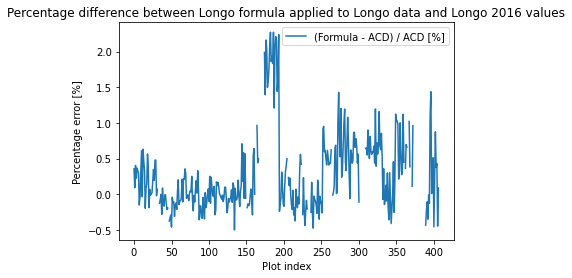

In [71]:
plt.plot((longo_acd_predictions-longo_acd) / longo_acd * 100, label="(Formula - ACD) / ACD [%]")
plt.title("Percentage difference between Longo formula applied to Longo data and Longo 2016 values")
plt.ylabel("Percentage error [%]")
plt.xlabel("Plot index")
plt.legend()

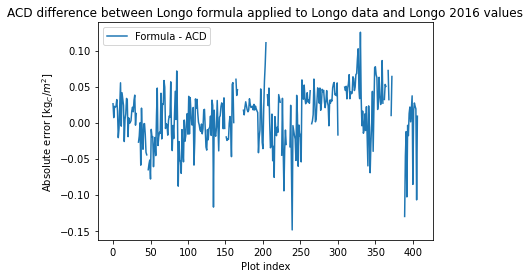

In [72]:
plt.title("ACD difference between Longo formula applied to Longo data and Longo 2016 values")
plt.plot(longo_acd_predictions-longo_acd, label="Formula - ACD")
plt.ylabel("Absolute error [kg$_C$/$m^2$]")
plt.xlabel("Plot index")
plt.legend();

Note: So the formula I implemented here seems to give mostly the same as the Longo predictions, but there is a slight tendency of the formula to predict a higher value than what Longo quote in their paper.
The error seems negiligible, at about $0.5-2\%$, with absolute values of $-0.1 \text{ to } 0.1$ kg$_C$/m$^2$.

## Check if ACD is in general larger than ABCD (it should always be)

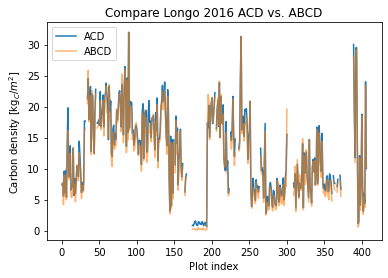

In [79]:
plt.plot(longo_acd, label="ACD")
plt.plot(longo_abcd, label="ABCD", alpha=0.6)
plt.title("Compare Longo 2016 ACD vs. ABCD")
plt.ylabel("Carbon density [kg$_C$/$m^2$]")
plt.xlabel("Plot index")
plt.legend()

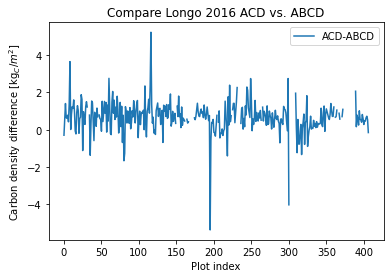

In [82]:
plt.plot(longo_acd-longo_abcd, label="ACD-ABCD")
plt.title("Compare Longo 2016 ACD vs. ABCD")
plt.ylabel("Carbon density difference [kg$_C$/$m^2$]")
plt.xlabel("Plot index")
plt.legend();

Should we ultimately estimate ACD or ABCD?